In [32]:
import dask.dataframe as dd
from IPython.display import display
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import binary_dilation
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
def log_func(x, a, b, c):
    return a * np.log(x + b) + c

In [33]:
def analyze_matrix(ddf, pickle_data):
    matrix = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
    matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
    def process_resource(i, resource_value):
        local_matrix = np.zeros(len(pickle_data['param_values_list_combination'][1]))
        local_matrix2 = np.zeros(len(pickle_data['param_values_list_combination'][1]))
        for j, phage_value in enumerate(pickle_data['param_values_list_combination'][1]):
            # print("processing resource", i, "phage", j)
            simulation_results = ddf.query(f'Resources == {resource_value} and Phages == {phage_value}').compute()
            y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[-1, :]
            if np.any(y_values > phage_value * 2):
                local_matrix[j] = np.max(y_values)
                local_matrix2[j] = 1
        return local_matrix, local_matrix2

    results = Parallel(n_jobs=-1)(
        delayed(process_resource)(i, resource_value)
        for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
    )

    for i, (col, col2) in enumerate(results):
        matrix[i, :] = col
        matrix2[i, :] = col2
    matrix = matrix.T
    matrix2 = matrix2.T
    return matrix, matrix2

In [61]:
from tkinter import font
from numpy import save


def create_plot(matrix, matrix2, pickle_data, save_fig=None, plot_curve_fit=True):
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.figure(figsize=(10, 6))
    plt.imshow(matrix, aspect='auto', origin='lower', cmap='viridis')

    boundary = np.logical_xor(matrix2, binary_dilation(matrix2))
    y_coords, x_coords = np.where(boundary)
    X = x_coords.reshape(-1, 1)
    y = y_coords
    mask = x_coords > 0
    x_log = x_coords[mask]
    y_log = y_coords[mask]

    def exp_func(x, a, b, c):
        return a * x / (b + x) + c

    popt, _ = curve_fit(exp_func, x_log, y_log, p0=(1, 0.01, 1), maxfev=10000)
    x_fit = np.linspace(x_log.min(), x_log.max(), 100)
    y_fit = exp_func(x_fit, *popt)
    y_pred = exp_func(x_log, *popt)
    r2 = r2_score(y_log, y_pred)
    a, b, c = popt
    if c < 0:
        label = f'Exp Fit: $y = \\frac{{{a:.3f} \\cdot x}}{{{b:.3f} + x}} {c:.3f}$\n$R^2 = {r2:.3f}$'
    else:
        label = f'Exp Fit: $y = \\frac{{{a:.3f} \\cdot x}}{{{b:.3f} + x}} + {c:.3f}$\n$R^2 = {r2:.3f}$'
    
    if plot_curve_fit:  
        plt.plot(x_fit, y_fit, color='black', linewidth=2, label=label)
        plt.legend(loc='lower right', fontsize=14)

    # Create a custom colormap: black for 0, red to green for >0
    colors = ['white'] + [plt.cm.Reds(i) for i in np.linspace(0.2, 1, 255)]
    cmap = ListedColormap(colors)
    bounds = [0, 1e-10] + list(np.linspace(matrix[matrix > 0].min(), matrix.max(), 255))
    norm = BoundaryNorm(bounds, cmap.N)

    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Value', ax=plt.gca())
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Value', fontsize=14)
    plt.imshow(matrix, aspect='auto', origin='lower', cmap=cmap, norm=norm)
    plt.xlabel('Resources', fontsize=14)
    plt.ylabel('Phages', fontsize=14)
    plt.title('Max Y Values For Phages If Proliferated \n Else 0 If Not Proliferated', fontsize=16)
    xtick_indices = np.arange(0, len(pickle_data['param_values_list_combination'][0]), 5)
    xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[xtick_indices]]
    ytick_indices = np.arange(0, len(pickle_data['param_values_list_combination'][1]), 5)
    ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[ytick_indices]]
    plt.xticks(ticks=xtick_indices, labels=xtick_labels, rotation=90, fontsize=12)
    plt.yticks(ticks=ytick_indices, labels=ytick_labels, fontsize=12)
    print(save)
    if save_fig != None:
        plt.savefig(f'LatexReport/Images/Plots/Created/PP/{save_fig}', dpi=300, bbox_inches='tight')

parameter_names_used ['Resources', 'Phages']
param_values_list_combination [[1.0, 4.138364779874214, 7.276729559748428, 10.415094339622641, 13.553459119496855, 16.69182389937107, 19.830188679245282, 22.968553459119498, 26.10691823899371, 29.245283018867923, 32.38364779874214, 35.522012578616355, 38.660377358490564, 41.79874213836478, 44.937106918238996, 48.075471698113205, 51.21383647798742, 54.35220125786164, 57.490566037735846, 60.62893081761006, 63.76729559748428, 66.90566037735849, 70.04402515723271, 73.18238993710692, 76.32075471698113, 79.45911949685535, 82.59748427672956, 85.73584905660377, 88.87421383647799, 92.0125786163522, 95.15094339622641, 98.28930817610063, 101.42767295597484, 104.56603773584905, 107.70440251572327, 110.84276729559748, 113.98113207547169, 117.11949685534591, 120.25786163522012, 123.39622641509433, 126.53459119496856, 129.67295597484278, 132.81132075471697, 135.9496855345912, 139.08805031446542, 142.22641509433961, 145.36477987421384, 148.50314465408806, 1

<Figure size 640x480 with 0 Axes>

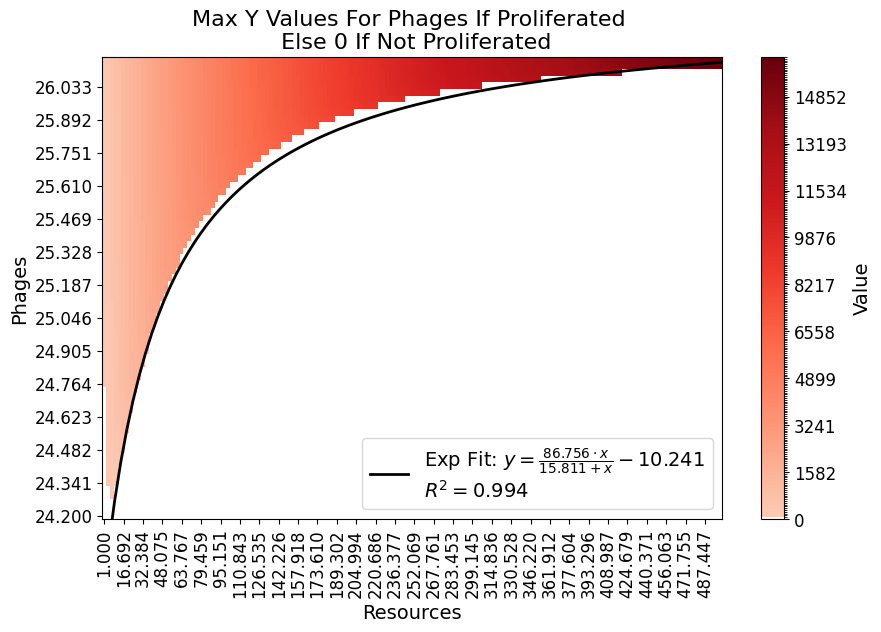

In [ ]:
parquet_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage/PhasePortraitResourcesPhage.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage/PhasePortraitResourcesPhage.pickle'


with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

ddf = dd.read_parquet(parquet_file_path, engine='pyarrow', 
                      include_partition_columns=True, 
                      gather_statistics=True, 
                      dtype_backend='pyarrow')
matrix, matrix2 = analyze_matrix(ddf, pickle_data)
create_plot(matrix, matrix2, pickle_data, save_fig='phase_portrait_resources_phage.png')


parameter_names_used ['Resources', 'Phages']
param_values_list_combination [[1.0, 1.7959183673469388, 2.5918367346938775, 3.387755102040816, 4.183673469387755, 4.979591836734694, 5.775510204081632, 6.571428571428571, 7.36734693877551, 8.16326530612245, 8.959183673469388, 9.755102040816327, 10.551020408163264, 11.346938775510203, 12.142857142857142, 12.938775510204081, 13.73469387755102, 14.53061224489796, 15.326530612244898, 16.122448979591837, 16.918367346938776, 17.714285714285715, 18.510204081632654, 19.306122448979593, 20.10204081632653, 20.897959183673468, 21.693877551020407, 22.489795918367346, 23.285714285714285, 24.081632653061224, 24.877551020408163, 25.6734693877551, 26.46938775510204, 27.26530612244898, 28.06122448979592, 28.857142857142858, 29.653061224489797, 30.448979591836736, 31.244897959183675, 32.04081632653062, 32.83673469387755, 33.63265306122449, 34.42857142857143, 35.224489795918366, 36.02040816326531, 36.816326530612244, 37.61224489795919, 38.40816326530612, 39.2

<Figure size 640x480 with 0 Axes>

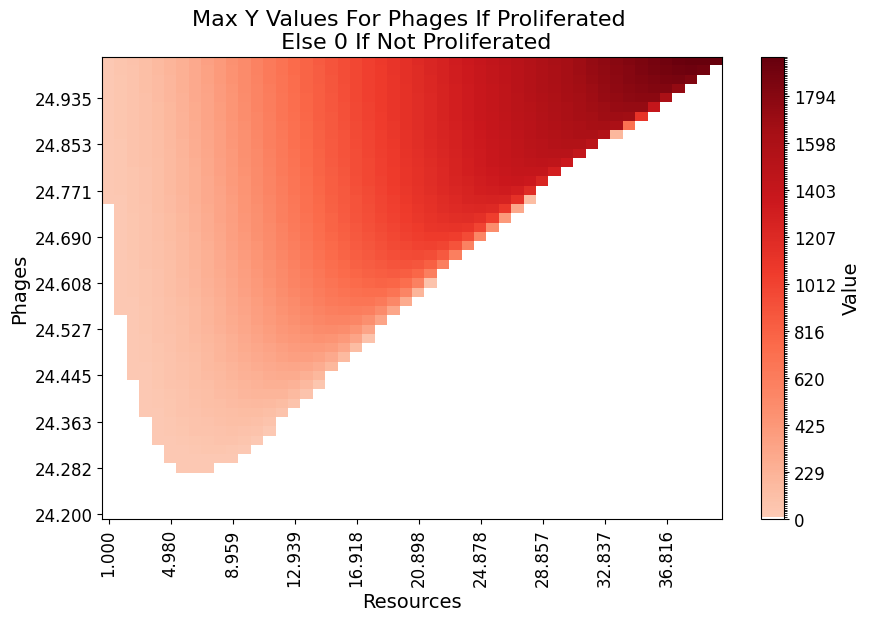

In [39]:
parquet_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage2/PhasePortraitResourcesPhage2.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage2/PhasePortraitResourcesPhage2.pickle'

with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

ddf = dd.read_parquet(parquet_file_path, engine='pyarrow', 
                      include_partition_columns=True, 
                      gather_statistics=True, 
                      dtype_backend='pyarrow')
matrix3, matrix4 = analyze_matrix(ddf, pickle_data)
create_plot(matrix3, matrix4, pickle_data, save_fig='phase_portrait_resources_phage_2.png', plot_curve_fit=False)
